# NFL Combine Regression Analysis

The goal of this project is to create a regression model that could be used to predict 40 yard dash times for college and at-home athletes. The requirements and features should be kept minimal to reduce the possibility of mis-measurement or needing special equipment. 

Approach:
1. Explore the data.
2. Attempt to use a few regression models on the full dataset.
3. Optimize the models.
4. Reduce features and compare the results to the full dataset.

In [1]:
# Import important standard libraries.
# ML models will be imported as we go.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [2]:
# Read the scraped and processed data.
combine_raw_df  = pd.read_csv('resources/combine_df.csv')

combine_raw_df.head()

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone
0,1987,Mike Adams,Arizona State,CB,69.8,198.0,28.6,4.42,13.0,32.0,118.0,4.60,NaN
1,1987,John Adickes,Baylor,C,74.8,266.0,33.4,4.97,25.0,26.5,103.0,4.60,NaN
2,1987,Tommy Agee,Auburn,FB,71.8,217.0,29.6,NaN,15.0,NaN,NaN,NaN,NaN
3,1987,David Alexander,Tulsa (OK),C,75.0,279.0,34.9,5.13,22.0,27.5,105.0,4.33,NaN
4,1987,Lyneal Alston,Southern Mississippi,WR,72.1,202.0,27.3,4.64,7.0,32.0,114.0,4.52,NaN


In [3]:
combine_raw_df.describe()

,Year,Height (in),Weight (lbs),BMI,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone
count,14164.000000,14164.000000,14164.000000,14164.000000,12634.000000,10276.000000,12178.000000,12055.000000,11099.000000,3810.000000
mean,2006.895792,73.754197,240.220983,30.859284,4.810259,19.813546,32.306150,113.403069,4.419774,7.263882
std,10.926223,2.651846,45.267732,4.429791,0.309922,6.474511,4.231685,9.759691,0.264741,0.383467
min,1987.000000,61.500000,142.000000,21.300000,4.210000,1.000000,17.500000,7.000000,3.730000,6.270000
25%,1997.000000,71.880000,203.000000,27.300000,4.570000,15.000000,29.500000,107.000000,4.230000,6.990000
50%,2008.000000,74.000000,231.500000,30.100000,4.730000,20.000000,32.500000,114.000000,4.380000,7.190000
75%,2017.000000,75.750000,276.000000,33.900000,5.020000,24.000000,35.375000,120.000000,4.580000,7.487500
max,2024.000000,82.400000,387.000000,47.700000,6.120000,51.000000,46.500000,147.000000,7.200000,8.820000


In [4]:
combine_raw_df.loc[combine_raw_df['40 Yard']==combine_raw_df['40 Yard'].min()]

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone
14161,2024,Xavier Worthy,Texas,WR,71.25,165.0,22.8,4.21,NaN,41.0,131.0,NaN,NaN


<AxesSubplot:ylabel='Frequency'>

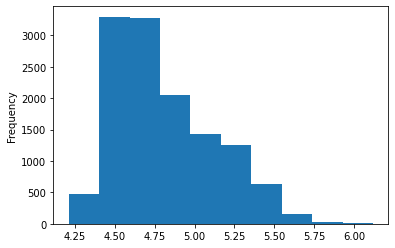

In [5]:
# Get a histogram of the 40 Yard data

combine_raw_df['40 Yard'].plot.hist()

For college athletes, it appears most of the 40 yard scores are in the 4.5 - 4.75 range. It should be noted that this data is trained using college athlete data, and not at-home athletes. If we had a control group, this chart could look very different.

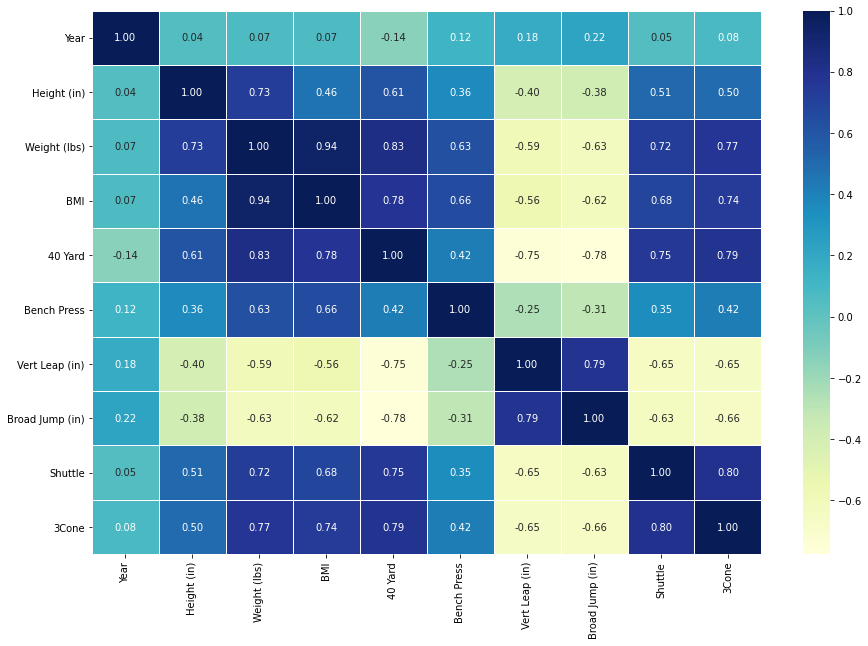

In [6]:
# Create correlation matrix to compare the features.

corr_matrix = combine_raw_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt='.2f',
                 cmap = 'YlGnBu')

<AxesSubplot:xlabel='Feature', ylabel='Correlation'>

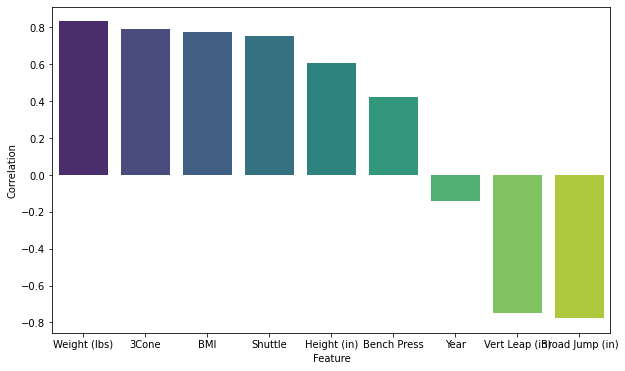

In [7]:
#Look specifically at 40 yard dash times.
corr_df = combine_raw_df.corr()

# Extract the correlation values for the '40 Yard' column
corr_40_yard = corr_df['40 Yard'].drop('40 Yard')  # Exclude the '40 Yard' itself to avoid a perfect correlation value of 1

# Convert to a DataFrame for easier plotting
corr_40_yard_df = corr_40_yard.reset_index()
corr_40_yard_df.columns = ['Feature', 'Correlation']

# Sort by correlation values for better visualization
corr_40_yard_df = corr_40_yard_df.sort_values(by='Correlation', ascending=False)

# Create a vertical bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_40_yard_df, x='Feature', y='Correlation', palette='viridis')

In this chart we can see that things like weight have a positive correlation with 40 yard dash times, meaning that the heavier an athlete is the higher their 40 yard dash time is likely to be. Broad Jump is negatively correlated with the 40 yard dash, so the further an athlete's broad jump the faster their 40 yard dash time. 

Although the 'year' feature has a correlation under -0.2, which may seem insignificant, we know that the average 40 yard dash times has decreased since it was first measured. As research and training programs improve we are likely to see this trend continue in the future. It's important to note context when looking at correlation and consider features even when the correlation appears low. 

### Prep the data for Machine Learning

We'll convert some of the text data to categories so that we can still use it. 

In [8]:
combine_df_ml = combine_raw_df.copy()

# This will turn all of the string values to category values
for label, content in combine_df_ml.items():
    if pd.api.types.is_string_dtype(content):
        combine_df_ml[label] = content.astype("category").cat.as_ordered()

combine_df_ml.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14164 entries, 0 to 14163
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Year             14164 non-null  int64   
 1   Name             14164 non-null  category
 2   College          14157 non-null  category
 3   POS              14164 non-null  category
 4   Height (in)      14164 non-null  float64 
 5   Weight (lbs)     14164 non-null  float64 
 6   BMI              14164 non-null  float64 
 7   40 Yard          12634 non-null  float64 
 8   Bench Press      10276 non-null  float64 
 9   Vert Leap (in)   12178 non-null  float64 
 10  Broad Jump (in)  12055 non-null  float64 
 11  Shuttle          11099 non-null  float64 
 12  3Cone            3810 non-null   float64 
dtypes: category(3), float64(9), int64(1)
memory usage: 1.8 MB


In order to keep as many rows as possible, we'll remove some of the features with that have a lot of null values. The 3Cone drill is missing a lot of values, and I'm assuming that bench press will have less of an impact on the other values. From previous exploration it seems many faster and lighter athletes opt out of the bench press. I'll also drop the name column based on the high number of unique values.

In [9]:
combine_df_ml.isnull().sum()

Year                   0
Name                   0
College                7
POS                    0
Height (in)            0
Weight (lbs)           0
BMI                    0
40 Yard             1530
Bench Press         3888
Vert Leap (in)      1986
Broad Jump (in)     2109
Shuttle             3065
3Cone              10354
dtype: int64

In [10]:
# Drop null values
combine_df_ml.drop(columns=['Bench Press', '3Cone'], inplace=True)
combine_df_ml.dropna(inplace=True)

In [11]:
combine_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10734 entries, 0 to 14160
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Year             10734 non-null  int64   
 1   Name             10734 non-null  category
 2   College          10734 non-null  category
 3   POS              10734 non-null  category
 4   Height (in)      10734 non-null  float64 
 5   Weight (lbs)     10734 non-null  float64 
 6   BMI              10734 non-null  float64 
 7   40 Yard          10734 non-null  float64 
 8   Vert Leap (in)   10734 non-null  float64 
 9   Broad Jump (in)  10734 non-null  float64 
 10  Shuttle          10734 non-null  float64 
dtypes: category(3), float64(7), int64(1)
memory usage: 1.4 MB


In [12]:
# Turn categories into numeric values so they work with the models.

for label, content in combine_df_ml.items():
    if not pd.api.types.is_numeric_dtype(content):
        #Turn categories into numbers and add +1
        combine_df_ml[label] = pd.Categorical(content).codes + 1

In [13]:
# Get the columns

combine_df_ml.columns

Index(['Year', 'Name', 'College', 'POS', 'Height (in)', 'Weight (lbs)', 'BMI',
       '40 Yard', 'Vert Leap (in)', 'Broad Jump (in)', 'Shuttle'],
      dtype='object')

In [14]:
# Split data into training and validation

df_val = combine_df_ml[combine_df_ml.Year > 2015]
df_train = combine_df_ml[combine_df_ml.Year <= 2015]

len(df_val)/len(combine_df_ml), len(df_train)/len(combine_df_ml)

(0.2692379355319545, 0.7307620644680455)

I originally selected 2017 as the year to split the data, which was close to 80% training and 20% validation. However, my MAE value was slightly better on the validation dataset when the year was 2015.

In [15]:
# Split data into X and y
X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((7844, 10), (7844,), (2890, 10), (2890,))

### Create Evaluation Metrics

We'll look at Mean Squared Error and R^2 to evaluate the model. We'll compare the training against the valid data to assess over and under fitting.

In [16]:
# Create evaluation function
from sklearn.metrics import mean_absolute_error, r2_score

# Create function to evaluate model o na few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
            "Valid MAE": mean_absolute_error(y_valid, val_preds),
            "Training R^2": r2_score(y_train, train_preds),
            "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

### Train and Test the Data Using Different Models

We'll start with Random Forest and see how that performs, then we'll look at other methods like Linear Regression and Lasso.

In [17]:
# Models from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

In [18]:
%%time
# Cutting down the max number of samples for each estimator can improve training time.
model.fit(X_train, y_train)

Wall time: 728 ms


RandomForestRegressor(n_jobs=-1, random_state=42)

In [19]:
show_scores(model)

{'Training MAE': 0.034106004589495115,
 'Valid MAE': 0.08984882352941176,
 'Training R^2': 0.9801658987363381,
 'Valid R^2': 0.85485369622086}

Our MAE looks a lot higher for the valid dataset versus the dataset for training. We are probably dealing with some overfitting here. There might be a few reasons for this, we may not have enough sample data or maybe the model is too complex. Acquiring more data is out of our hands, but we could possibly adjust the datasets to get more values in the training dataset. we could also try different model to see if that helps. Identifying and removing outliers could help with predictions as well and will be the first place we start.

In [20]:
# Check Z Scores in our data
from scipy.stats import zscore

for column in list(combine_df_ml.columns):
    print(f"{column}: ", abs(zscore(combine_df_ml[column]).max().round(2)))

Year:  1.61
Name:  1.75
College:  1.71
POS:  1.28
Height (in):  3.24
Weight (lbs):  3.21
BMI:  3.78
40 Yard:  4.19
Vert Leap (in):  3.38
Broad Jump (in):  3.49
Shuttle:  10.52


In [21]:

combine_df_ml_no_outliers = combine_df_ml.copy()

# Calculate z-scores for all columns at once and take the absolute values
z_scores_df = np.abs(combine_df_ml_no_outliers.apply(zscore))

# Set threshold
threshold = 2

# Filter rows where z-scores in all columns are below the threshold
combine_df_ml_no_outliers = combine_df_ml_no_outliers[(z_scores_df < threshold).all(axis=1)]

# Verify if the outliers are removed by checking max z-scores in each column
for column in list(combine_df_ml_no_outliers.columns):
    print(f"{column}: ", abs(zscore(combine_df_ml_no_outliers[column]).max().round(2)))


Year:  1.61
Name:  1.75
College:  1.71
POS:  1.25
Height (in):  2.24
Weight (lbs):  2.41
BMI:  2.42
40 Yard:  2.57
Vert Leap (in):  2.2
Broad Jump (in):  2.26
Shuttle:  2.6


In [22]:
combine_df_ml_no_outliers.sort_values(by='Broad Jump (in)', ascending=True)

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Vert Leap (in),Broad Jump (in),Shuttle
3695,1998,7176,195,24,78.80,270.0,30.6,5.16,26.5,94.0,4.45
7431,2009,8114,433,15,77.13,328.0,38.8,5.37,24.0,94.0,4.89
1152,1990,12480,340,4,75.60,268.0,33.0,5.22,26.5,94.0,4.65
12830,2021,13031,319,13,72.75,233.0,30.9,5.18,25.5,94.0,4.79
1178,1990,6679,282,18,76.30,287.0,34.7,5.27,25.0,94.0,4.60
...,...,...,...,...,...,...,...,...,...,...,...
3275,1996,5882,258,25,72.60,187.0,24.9,4.66,38.5,132.0,4.34
13403,2022,13690,316,2,74.13,199.0,25.5,4.33,39.5,132.0,3.94
10569,2016,2883,140,2,70.88,193.0,27.0,4.49,33.0,132.0,4.33
13812,2023,2731,304,2,75.38,205.0,25.4,4.47,35.5,132.0,4.06


In [23]:
# Try random forest again

# Split data into training and validation

df_val = combine_df_ml_no_outliers[combine_df_ml_no_outliers.Year > 2015]
df_train = combine_df_ml_no_outliers[combine_df_ml_no_outliers.Year <= 2015]

# Split data into X and y
X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

# Cutting down the max number of samples for each estimator can improve training time.
model.fit(X_train, y_train)

show_scores(model)



{'Training MAE': 0.032789464958553116,
 'Valid MAE': 0.08671516762060509,
 'Training R^2': 0.9734398835135702,
 'Valid R^2': 0.8182820037089447}

There was a modest increase in our Valid MAE, which could be usefull in the future.

In [24]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(n_jobs=-1)

lin_model.fit(X_train,y_train)

show_scores(lin_model)

{'Training MAE': 0.09206120598416728,
 'Valid MAE': 0.09360129342145683,
 'Training R^2': 0.7951319737594724,
 'Valid R^2': 0.7869176716068172}

The training MAE and valid MAE are much closer using linear regression, however our valid MAE is still higher than we saw with the random forest model.

We'll use Lasso, Ridge, and ElasticNet (a combination of both) next. Theses algorithms are known for balancing the impact of highly correlated features, so this may help us reduce error.

In [25]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

ridge = Ridge(alpha=1,random_state=42)
lasso = Lasso(alpha=0.1, random_state=42)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.2, random_state=42)

ridge.fit(X_train,y_train)
lasso.fit(X_train,y_train)
elastic_net.fit(X_train,y_train)

print("ridge: ",show_scores(ridge))
print("lasso: ",show_scores(lasso))
print("elastic_net: ", show_scores(elastic_net))

ridge:  {'Training MAE': 0.09206227553195082, 'Valid MAE': 0.0936180935142822, 'Training R^2': 0.7951317263420602, 'Valid R^2': 0.7868357740382035}
lasso:  {'Training MAE': 0.09797738066467218, 'Valid MAE': 0.09777559487170663, 'Training R^2': 0.7688155657812956, 'Valid R^2': 0.7637374127049695}
elastic_net:  {'Training MAE': 0.09452577255542415, 'Valid MAE': 0.09789425371679102, 'Training R^2': 0.7846595063785673, 'Valid R^2': 0.7661903165973427}


In [26]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Off the bat, it does not look like it's giving us any improvement over our linear regression or random forest models. So we may try a different approach by optimizing our random forest model.

We'll use RandomSearchCV to test different parameters and see if some of them help us improve our MAE and reduce over fitting.

In [27]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Dfferent RandomForestRegressor hyper parameters
rs_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rs_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

# For the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 1min 55s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [28]:
# Find the best hyperparams
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': None}

In [32]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 0.06400206347414981,
 'Valid MAE': 0.0847823611044161,
 'Training R^2': 0.8986575458208288,
 'Valid R^2': 0.8254511559327943}

The results show both a decrease in Valid MAE and the difference between Training and Valid MAE. A nice improvement.

We'll see if a boosted model like XGBoost can provide even better results than what we've seen.

In [33]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_jobs=-1, random_state = 42)

xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [34]:
show_scores(xgb_model)

{'Training MAE': 0.04203814085534217,
 'Valid MAE': 0.0901916420079603,
 'Training R^2': 0.9537379519009024,
 'Valid R^2': 0.8021921342991626}

In [35]:
# Instantiate RandomizedSearchCV model for XGBoost
rs_xgb_model = RandomizedSearchCV(XGBRegressor(n_jobs=-1,
                                        random_state=42),
                              param_distributions=rs_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

In [36]:
rs_xgb_model.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[09:17:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:17:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:17:01] WA

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          num_parallel_tree=None,
                                        

In [37]:
# Evaluate the RandomizedSearch model
show_scores(rs_xgb_model)

{'Training MAE': 0.07692416484749398,
 'Valid MAE': 0.08680865127145512,
 'Training R^2': 0.8574513987800283,
 'Valid R^2': 0.8166197828293111}

Despite boosting and the same optimization criteria, XGBoost is not performing better than random forest, even when optimizing. We'll try one more model, CatBoost.

In [38]:
from catboost import CatBoostRegressor

cb_model = CatBoostRegressor(random_seed=42)

cb_model.fit(X_train,y_train)

show_scores(cb_model)


Learning rate set to 0.055212
0:	learn: 0.2471851	total: 155ms	remaining: 2m 34s
1:	learn: 0.2378595	total: 157ms	remaining: 1m 18s
2:	learn: 0.2287652	total: 158ms	remaining: 52.6s
3:	learn: 0.2204468	total: 160ms	remaining: 39.9s
4:	learn: 0.2125511	total: 162ms	remaining: 32.2s
5:	learn: 0.2052059	total: 164ms	remaining: 27.2s
6:	learn: 0.1984516	total: 166ms	remaining: 23.6s
7:	learn: 0.1916525	total: 168ms	remaining: 20.9s
8:	learn: 0.1856708	total: 171ms	remaining: 18.8s
9:	learn: 0.1800520	total: 172ms	remaining: 17.1s
10:	learn: 0.1748587	total: 174ms	remaining: 15.7s
11:	learn: 0.1700441	total: 177ms	remaining: 14.5s
12:	learn: 0.1654892	total: 179ms	remaining: 13.6s
13:	learn: 0.1614059	total: 181ms	remaining: 12.7s
14:	learn: 0.1575186	total: 183ms	remaining: 12s
15:	learn: 0.1539998	total: 185ms	remaining: 11.4s
16:	learn: 0.1505287	total: 187ms	remaining: 10.8s
17:	learn: 0.1475754	total: 189ms	remaining: 10.3s
18:	learn: 0.1447064	total: 191ms	remaining: 9.87s
19:	learn: 

{'Training MAE': 0.06003223200979192,
 'Valid MAE': 0.08444970009034142,
 'Training R^2': 0.9118982968497467,
 'Valid R^2': 0.8270548434315765}

We immediately see an improvement with Catboost, which is exciting. Let's optimize it and see what happens. CatBoost has some different parameters than RandomForest and XGBoost.

In [39]:
# Instantiate RandomizedSearchCV model for XGBoost

cb_grid = {'depth': [6,8,10],
           'learning_rate': [0.01, 0.05, 0.10],
           'iterations':   [200,150]}

rs_cb_model = RandomizedSearchCV(CatBoostRegressor(random_state=42),
                              param_distributions=cb_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

rs_cb_model.fit(X_train,y_train)

show_scores(rs_cb_model)

c:\Users\seanc\anaconda3\envs\PythonData\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
0:	learn: 0.2564452	total: 1.95ms	remaining: 388ms
1:	learn: 0.2546094	total: 3.9ms	remaining: 387ms
2:	learn: 0.2527985	total: 5.54ms	remaining: 364ms
3:	learn: 0.2509718	total: 7.16ms	remaining: 351ms
4:	learn: 0.2491920	total: 8.96ms	remaining: 350ms
5:	learn: 0.2474662	total: 11ms	remaining: 355ms
6:	learn: 0.2457566	total: 12.6ms	remaining: 348ms
7:	learn: 0.2440391	total: 14.2ms	remaining: 341ms
8:	learn: 0.2423079	total: 15.8ms	remaining: 334ms
9:	learn: 0.2406218	total: 17.5ms	remaining: 333ms
10:	learn: 0.2389606	total: 19.2ms	remaining: 329ms
11:	learn: 0.2372604	total: 20.9ms	remaining: 327ms
12:	learn: 0.2356930	total: 22.5ms	remaining: 324ms
13:	learn: 0.2340591	total: 24.6ms	remaining: 326ms
14:	learn: 0.2324759	total: 26.5ms	remaining: 327ms
15:	learn: 0.2308719	total: 28.3ms	remaining: 326ms
16:	learn: 0.2292839	total: 30.1ms	remaining: 324ms
17:	learn: 0.2277256	total: 31.7ms	remaining: 321ms
18:	learn: 0.226

{'Training MAE': 0.0769607784734913,
 'Valid MAE': 0.08329764239551063,
 'Training R^2': 0.857500073089176,
 'Valid R^2': 0.8316011925157688}

The optimized Catboost model has the best performance we've seen. We'll use Catboost and Random Forest to try and create a model athletes can test at home.

### Reducing Features
 Broad jump and vertical leap were both highly correlated with the 40 yard dash, but vertical leap is slightly more difficult to measure at home. This being the case, we'll attempt to create a model using only broad jump as a performance metric.

We'll compare against the previous model to see how much of an error difference we get by dropping columns.

In [49]:
combine_df_ml_no_outliers.columns

Index(['Year', 'Name', 'College', 'POS', 'Height (in)', 'Weight (lbs)', 'BMI',
       '40 Yard', 'Vert Leap (in)', 'Broad Jump (in)', 'Shuttle'],
      dtype='object')

In [50]:
# Create datasets with reduced columns
combine_df_reduced_ml = combine_df_ml_no_outliers.drop(columns=['Name', 'College', 'POS', 'Vert Leap (in)','BMI','Vert Leap (in)','Shuttle'])

# Create a list of all of the models to test
dfs_to_test = [combine_df_ml, combine_df_ml_no_outliers, combine_df_reduced_ml]
df_names = ["combine_df_ml", "combine_df_ml_no_outliers", "combine_df_reduced_ml"]

df_dict = dict(zip(df_names, dfs_to_test))

# Get a list of the columns for each of the dataframes we'll test
for key, value in df_dict.items():
    print(key,f':\n',list(value.columns))


combine_df_ml :
 ['Year', 'Name', 'College', 'POS', 'Height (in)', 'Weight (lbs)', 'BMI', '40 Yard', 'Vert Leap (in)', 'Broad Jump (in)', 'Shuttle']
combine_df_ml_no_outliers :
 ['Year', 'Name', 'College', 'POS', 'Height (in)', 'Weight (lbs)', 'BMI', '40 Yard', 'Vert Leap (in)', 'Broad Jump (in)', 'Shuttle']
combine_df_reduced_ml :
 ['Year', 'Height (in)', 'Weight (lbs)', '40 Yard', 'Broad Jump (in)']



The default variables for random forest worked well for the last models. We'll use that to compare the dataframes we have here.

In [51]:
#Cycle through our dfs and create a dataframe of the model scores

df_scores = pd.DataFrame()

combine_score_predictive_model = CatBoostRegressor(**rs_cb_model.best_params_,random_state=42)

for name, df in df_dict.items():

    df_temp = df.copy()

    # Split data into training and validation
    df_val = df_temp[df_temp.Year > 2015]
    df_train = df_temp[df_temp.Year <= 2015]

    # Split data into X and y
    X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
    X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

    combine_score_predictive_model.fit(X_train, y_train)

    # Create a dictionary from the scores
    scores_dict = show_scores(combine_score_predictive_model)

    # Append name to dicitionary
    scores_dict['Version'] = name

    df_scores = df_scores.append(scores_dict, ignore_index=True)

# Rearrange the columns
cols = ['Version'] + [col for col in df_scores.columns if col != 'Version']
df_scores = df_scores[cols]

# Display the final scores dataframe with 'Model' as the first column
df_scores

0:	learn: 0.2991406	total: 5.62ms	remaining: 837ms
1:	learn: 0.2877550	total: 10.2ms	remaining: 753ms
2:	learn: 0.2772801	total: 14.6ms	remaining: 714ms
3:	learn: 0.2671434	total: 18.4ms	remaining: 671ms
4:	learn: 0.2574935	total: 22.3ms	remaining: 645ms
5:	learn: 0.2484791	total: 26.7ms	remaining: 640ms
6:	learn: 0.2401241	total: 30.2ms	remaining: 616ms
7:	learn: 0.2321228	total: 33.9ms	remaining: 602ms
8:	learn: 0.2243541	total: 37.2ms	remaining: 583ms
9:	learn: 0.2173013	total: 42.4ms	remaining: 594ms
10:	learn: 0.2105804	total: 47ms	remaining: 594ms
11:	learn: 0.2042720	total: 50.4ms	remaining: 580ms
12:	learn: 0.1983724	total: 54.1ms	remaining: 570ms
13:	learn: 0.1925999	total: 59.8ms	remaining: 580ms
14:	learn: 0.1872629	total: 63.2ms	remaining: 569ms
15:	learn: 0.1822334	total: 66.5ms	remaining: 557ms
16:	learn: 0.1774893	total: 70ms	remaining: 548ms
17:	learn: 0.1732688	total: 75ms	remaining: 550ms
18:	learn: 0.1689568	total: 78.7ms	remaining: 543ms
19:	learn: 0.1650972	total: 

,Version,Training MAE,Training R^2,Valid MAE,Valid R^2
0,combine_df_ml,0.082408,0.887082,0.087292,0.864604
1,combine_df_ml_no_outliers,0.076961,0.857500,0.083298,0.831601
2,combine_df_reduced_ml,0.085271,0.824069,0.088657,0.806676


Based on the current values as of writing, the valid MAE of the original Combine DF is -10.6% lower than the Reduced Combine DF without Vertical Leap. As an amatuer Machine Learning Engineer, it's difficult to assess the impact of this based on the error calculation alone. Let's compare the predicted values of each version compared against each other and the actual values.

In [52]:
# Cycle through our dfs and create a df for the predicted values 

df_preds = pd.DataFrame()

for name, df in df_dict.items():

    df_temp = df.copy()

    # Split data into training and validation
    df_val = df_temp[df_temp.Year > 2015]
    df_train = df_temp[df_temp.Year <= 2015]

    # Split data into X and y
    X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
    X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

    combine_score_predictive_model.fit(X_train, y_train)

    # Create a dictionary from the scores
    y_pred = combine_score_predictive_model.predict(X_valid)

    # Append name to dicitionary
    name_predictions ="y_preds: " + name

    df_preds[name_predictions] = pd.Series(y_pred)


# Add the actual values, should be the same after the loop
df_valid = combine_df_ml[combine_df_ml.Year > 2015]
y_valid = df_valid['40 Yard'].reset_index(drop=True)

df_preds['y_valid'] = y_valid

# Show the results:
df_preds.head(20)

0:	learn: 0.2991406	total: 6.86ms	remaining: 1.02s
1:	learn: 0.2877550	total: 11.7ms	remaining: 869ms
2:	learn: 0.2772801	total: 15.9ms	remaining: 781ms
3:	learn: 0.2671434	total: 21.6ms	remaining: 790ms
4:	learn: 0.2574935	total: 25.9ms	remaining: 750ms
5:	learn: 0.2484791	total: 29.5ms	remaining: 707ms
6:	learn: 0.2401241	total: 33.4ms	remaining: 682ms
7:	learn: 0.2321228	total: 37.6ms	remaining: 667ms
8:	learn: 0.2243541	total: 41.1ms	remaining: 645ms
9:	learn: 0.2173013	total: 44.9ms	remaining: 628ms
10:	learn: 0.2105804	total: 48.5ms	remaining: 613ms
11:	learn: 0.2042720	total: 52.6ms	remaining: 605ms
12:	learn: 0.1983724	total: 56.1ms	remaining: 592ms
13:	learn: 0.1925999	total: 59.3ms	remaining: 576ms
14:	learn: 0.1872629	total: 63ms	remaining: 567ms
15:	learn: 0.1822334	total: 66.5ms	remaining: 557ms
16:	learn: 0.1774893	total: 70.2ms	remaining: 549ms
17:	learn: 0.1732688	total: 73.5ms	remaining: 539ms
18:	learn: 0.1689568	total: 77.2ms	remaining: 533ms
19:	learn: 0.1650972	tot

,y_preds: combine_df_ml,y_preds: combine_df_ml_no_outliers,y_preds: combine_df_reduced_ml,y_valid
0,5.017559,5.012844,5.025573,5.10
1,4.738436,4.739549,4.763154,4.64
2,4.698929,4.713618,4.581280,4.83
3,4.518158,4.509535,4.556284,4.66
4,4.880066,4.842067,4.850533,4.76
5,4.494083,4.499907,4.510505,4.49
6,5.391382,4.835887,4.716833,5.57
7,4.818453,5.212815,5.100029,4.84
8,5.228819,4.536711,4.530568,5.29
9,4.537325,4.511540,4.513204,4.67


In [53]:
# Split up the data for just the feature reduced dataset

# Split data into training and validation
df_val = combine_df_reduced_ml[df_temp.Year > 2015]
df_train = combine_df_reduced_ml[df_temp.Year <= 2015]

# Split data into X and y
X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

combine_score_predictive_model.fit(X_train, y_train)

# For the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

show_scores(combine_score_predictive_model)

0:	learn: 0.2482109	total: 5.67ms	remaining: 845ms
1:	learn: 0.2392221	total: 18.2ms	remaining: 1.35s
2:	learn: 0.2307578	total: 23.6ms	remaining: 1.15s
3:	learn: 0.2230880	total: 28.2ms	remaining: 1.03s
4:	learn: 0.2156939	total: 31.3ms	remaining: 908ms
5:	learn: 0.2085215	total: 34.1ms	remaining: 818ms
6:	learn: 0.2020502	total: 43.4ms	remaining: 886ms
7:	learn: 0.1957735	total: 46.8ms	remaining: 831ms
8:	learn: 0.1901736	total: 49.4ms	remaining: 774ms
9:	learn: 0.1848053	total: 52.2ms	remaining: 731ms
10:	learn: 0.1797455	total: 55.1ms	remaining: 696ms
11:	learn: 0.1750972	total: 57.7ms	remaining: 664ms
12:	learn: 0.1705286	total: 60.3ms	remaining: 636ms
13:	learn: 0.1664298	total: 63.1ms	remaining: 613ms
14:	learn: 0.1625717	total: 65.9ms	remaining: 593ms
15:	learn: 0.1589057	total: 68.5ms	remaining: 574ms
16:	learn: 0.1555499	total: 71.5ms	remaining: 560ms
17:	learn: 0.1524237	total: 74.2ms	remaining: 544ms
18:	learn: 0.1493516	total: 76.8ms	remaining: 530ms
19:	learn: 0.1466176	t

{'Training MAE': 0.08527108269758038,
 'Valid MAE': 0.08865744855826638,
 'Training R^2': 0.8240689001418419,
 'Valid R^2': 0.8066764762779015}

In [56]:
# Create a new model with the new parameters
rs_combine_score_predictive_model = RandomizedSearchCV(CatBoostRegressor(random_state=42),
                              param_distributions=cb_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

rs_combine_score_predictive_model.fit(X_train, y_train)

show_scores(rs_combine_score_predictive_model)

c:\Users\seanc\anaconda3\envs\PythonData\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
0:	learn: 0.2563950	total: 2.38ms	remaining: 473ms
1:	learn: 0.2546068	total: 4.21ms	remaining: 417ms
2:	learn: 0.2527578	total: 6.17ms	remaining: 405ms
3:	learn: 0.2509961	total: 7.78ms	remaining: 381ms
4:	learn: 0.2491688	total: 9.52ms	remaining: 371ms
5:	learn: 0.2473494	total: 11.6ms	remaining: 374ms
6:	learn: 0.2455723	total: 13.4ms	remaining: 370ms
7:	learn: 0.2438892	total: 14.8ms	remaining: 356ms
8:	learn: 0.2421732	total: 16.8ms	remaining: 356ms
9:	learn: 0.2405127	total: 19.1ms	remaining: 363ms
10:	learn: 0.2388633	total: 21ms	remaining: 361ms
11:	learn: 0.2372222	total: 22.8ms	remaining: 357ms
12:	learn: 0.2355672	total: 24.6ms	remaining: 355ms
13:	learn: 0.2339232	total: 26.5ms	remaining: 351ms
14:	learn: 0.2323242	total: 28.1ms	remaining: 346ms
15:	learn: 0.2307430	total: 29.6ms	remaining: 340ms
16:	learn: 0.2291485	total: 31ms	remaining: 334ms
17:	learn: 0.2276031	total: 33.1ms	remaining: 335ms
18:	learn: 0.2260

{'Training MAE': 0.08739240983484121,
 'Valid MAE': 0.08857749531193836,
 'Training R^2': 0.8151976473569946,
 'Valid R^2': 0.8067265937587526}

In [58]:
combine_score_predictive_model = CatBoostRegressor(**rs_combine_score_predictive_model.best_params_,random_state=42)

combine_score_predictive_model.fit(X_train,y_train)

# Save the model for future use.
import pickle

pickle.dump(combine_score_predictive_model, open('combine_score_predictive_model.pkl', 'wb'))



0:	learn: 0.2482884	total: 2.36ms	remaining: 351ms
1:	learn: 0.2398006	total: 4.75ms	remaining: 352ms
2:	learn: 0.2315159	total: 7.51ms	remaining: 368ms
3:	learn: 0.2239136	total: 9.58ms	remaining: 350ms
4:	learn: 0.2164142	total: 11.5ms	remaining: 334ms
5:	learn: 0.2095041	total: 13.6ms	remaining: 327ms
6:	learn: 0.2031063	total: 15.6ms	remaining: 319ms
7:	learn: 0.1973381	total: 17.3ms	remaining: 308ms
8:	learn: 0.1917979	total: 19.2ms	remaining: 301ms
9:	learn: 0.1865718	total: 21.2ms	remaining: 297ms
10:	learn: 0.1814854	total: 23.4ms	remaining: 296ms
11:	learn: 0.1767419	total: 25.3ms	remaining: 291ms
12:	learn: 0.1723676	total: 27.3ms	remaining: 288ms
13:	learn: 0.1684125	total: 29.3ms	remaining: 284ms
14:	learn: 0.1645374	total: 31.5ms	remaining: 284ms
15:	learn: 0.1608497	total: 33.6ms	remaining: 282ms
16:	learn: 0.1575310	total: 36.6ms	remaining: 286ms
17:	learn: 0.1545108	total: 38.7ms	remaining: 284ms
18:	learn: 0.1516386	total: 40.4ms	remaining: 278ms
19:	learn: 0.1488839	t

In [61]:
# Get predictions from each tree
predictions_per_iteration = np.array([combine_score_predictive_model.predict(X_valid, ntree_end=i) for i in range(1, combine_score_predictive_model.tree_count_ + 1)])

# Calculate prediction mean
mean_prediction = np.mean(predictions_per_iteration, axis=0)

# Calculate prediction intervals (e.g., 90% confidence)
lower_bound = np.percentile(predictions_per_iteration, 5, axis=0)
upper_bound = np.percentile(predictions_per_iteration, 95, axis=0)

# Display bounds

data = {'y valid': y_valid, 
        'prediction': mean_prediction, 
        'lower bound': lower_bound, 
        'upper bound': upper_bound}

bounded_predictions_df = pd.DataFrame(data)

bounded_predictions_df.sample(10)

,y valid,prediction,lower bound,upper bound
11439,4.82,4.948141,4.851012,4.976170
11732,4.66,4.582303,4.548394,4.720942
11302,5.15,5.107272,4.915878,5.160246
12044,4.73,4.689649,4.671850,4.748266
11966,4.81,4.567099,4.537854,4.697086
13109,5.05,4.827043,4.817892,4.834964
11240,4.81,4.652114,4.630456,4.740669
11841,4.59,4.547524,4.513484,4.693909
13758,4.73,4.719003,4.701986,4.746612
11217,4.45,4.535683,4.496654,4.693241
